# Policy Improvement

Previously, we learned how to solve the **prediction problem**: how to accurately estimate the value function of a given policy. However, while this is a useful ability for our agents to have, it doesn’t directly make them better at any task. Now, we learn how to solve the **control problem**: how to make agents optimize policies. This ability allows agents to **learn optimal behavior by trial-and-error learning**, starting from arbitrary policies and ending in optimal ones. 

Instead of estimating state-value function, we estimate action-value functions **to see the value of actions without having to use an MDP**. Then, after we obtain this esteem, we use it to improve the policy. This is similar to what we did in the policy-iteration algorithm in Dynamic Programming: we evaluate, we improve, then evaluate the improved policy, then improve on this improved policy, and so on....

$\pi_0 \overset{evaluate}{\longrightarrow }  q_{\pi_0} \overset{improve}{\longrightarrow } \pi_1 \overset{evaluate}{\longrightarrow }  q_{\pi_1} \overset{improve}{\longrightarrow } \pi_2 \overset{evaluate}{\longrightarrow } ... \overset{improve}{\longrightarrow } \pi_* \overset{evaluate}{\longrightarrow }  q_{\pi_*}$

Policy improvement is done by making the policy greedy with respect to the current value function. In this case we have an action-value function, and therefore no model is needed to construct the greedy policy. For any action-value function, the corresponding greedy policy is the one that, for each state, deterministically chooses an action with maximal action-value:

$\displaystyle \pi(s) = \underset{a}{\arg \max}\> q(s,a) $

This pattern is called **generalized policy iteration (GPI)**, and it can help us create an architecture that virtually any reinforcement learning algorithm fits under, including state-of-the-art deep reinforcement learning agents.


## Slippery Walk environment

We use an environment called **Slippery Walk**. This environment is a walk, a single-row grid-world environment, with seven non-terminal states. The particular thing of this environment is that it’s slippery, like the Fronzen Lake: **action effects are stochastic**. If the agent chooses to go left, there is a chance it does, but there is also a chance that it goes right, or that it stays in place.

<img src="./images/slippery-walk.png" width="600">

This environment is noisy, but the actions the agent selects make a difference in its performance.

In [1]:
import random
import numpy as np
        
class SlipperyWalk:
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = 9
        self.action_space = 2
        self._state = np.random.choice([1,2,3,4,5,6,7])
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')
        
        if(action==0): direction = -1
        if(action==1): direction = 1
        
        direction_list = [direction, -direction, 0]
        true_direction = random.choices(direction_list, weights=(50, 17, 33), k=1)
        self._state += true_direction[0]
        
        reward = 0
        if self._state < 1: self._done = True
        if self._state > 7: self._done = True; reward = 1
        return self._state, reward, self._done, 0  # obs, rew, done

In [2]:
slippery_walk = SlipperyWalk()

The optimal state value function can be calculated using the MDP and applying the Dynamic Programming:

In [3]:
optimal_V = [0., 0.5637, 0.763, 0.8449, 0.8892, 0.922, 0.9515, 0.9806, 0.]  

## Improving policies after each episode: Monte Carlo control

Policy improvement can be done by constructing each successive policy as the greedy policy with respect to the current estimate of the action-value function: 

$\displaystyle \pi_{k+1}(s) = \underset{a}{\arg \max}\> q_{\pi_k}(s,a) $

The **policy improvement theorem** (as already considered in Dynamic Programming) assures that each new policy is better than (or just as good as) the previous one, so the overall process converges to the optimal policy and optimal value function:

$\displaystyle q_{\pi_k}(s, \pi_{k+1}(s)) = q_{\pi_k}(s, \underset{a}{\arg \max}\> q_{\pi_k}(s,a)) 
 = \underset{a}{\max \>} q_{\pi_k}(s,a)) \geq q_{\pi_k}(s, \pi_k(s)) \geq v_{\pi_k}(s) $



First, we need to make sure our agent **estimates the action-value function, instead of the state-value function**, in order to know what the best action is to take from a state. 

Second, we need to **make sure our agent explores**. The problem is that we’re no longer using the MDP for our policy-evaluation needs. When we estimate from samples, we get values for all of the state-action pairs we visited, but what if part of the best states weren’t visited? 

Let’s use **first-visit Monte Carlo prediction** for the policy-evaluation phase and a **decaying epsilon-greedy action-selection strategy** for the policy-improvement phase. 

In order to decay alpha and epsilon, we use the same decay schedule function used in policy evaluation:

In [4]:
def decay_schedule(init_value, min_value, decay_steps, max_steps):
    rem_steps = max_steps - decay_steps
    values = np.logspace(start=0, stop=-2, num=decay_steps, base=10)
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

We create also a function to calculate all the discount values for the full process:

In [5]:
def decay_discounts(gamma, max_steps):
    discounts = np.logspace(start=0, stop=max_steps, num=max_steps, base=gamma, endpoint=False);
    return discounts

The generate_trajectory function is slightly different: now we need to select an action following a strategy, instead of a greedy policy:

In [6]:
def generate_trajectory(select_action, Q, epsilon, env, max_steps=200):

    # list of experiences (trajectory)
    trajectory = []

    done = False
    steps = 0

    # reset the environment to interact in a new episode
    state = env.reset()

    # looping through until the done flag is set to true
    while not done:
        steps += 1; 

        # here is the difference: use the ‘select_action’ 
        # function to pick an action
        action = select_action(state, Q, epsilon) 
            
        # step the environment using that action
        next_state, reward, done, _ = env.step(action)

        # append the experience to the trajectory
        experience = (state, action, reward, next_state, done)
        trajectory.append(experience)
        
         # if we hit a terminal state break and return
        if done:
            break

        # truncate long trajectories 
        if steps > max_steps:
            break;   
       
        # update the state
        state = next_state
    
    # return the trajectory
    return np.array(trajectory, object)

Then we can write the Monte Carlo control algorithm, which is similar to the prediction. The two main differences is that we now estimate the action-value function Q, and that we need to explore (we use an decaying epsilon to control random exploration).

In [7]:
def select_action(state, Q, epsilon):
    if np.random.uniform() > epsilon:
        action = np.argmax(Q[state])
    else:
        action = np.random.randint(len(Q[0]))

    return action;

In [12]:
def mc_control(env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, init_epsilon=1.0, min_epsilon=0.1, decay_episodes=350,
               n_episodes=2000, max_steps=200):
    
    nS, nA = env.observation_space, env.action_space
    
    # calculate all discounts at once. 
    discounts = decay_discounts(gamma, max_steps);
    
    # calculate all alphas at once
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes);
        
    # calculate all epsilons in advance
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes)
    
    # setting up variables
    pi_track = []
    Q = np.zeros((nS, nA), dtype=float)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
    
    # the episode loop    
    for e in range(n_episodes):
        
        # generate a trajectory using the exploratory policy
        trajectory = generate_trajectory(select_action, Q, epsilons[e], env, max_steps)
        
        # keep track of the visits to state-action pairs
        visited = np.zeros((nS, nA), dtype=bool)
        
        # process the trajectory offline, after the interactions with the 
        # environment have stopped
        for t, (state, action, reward, _, _) in enumerate(trajectory):
            
            # check for state-action pair visits
            if visited[state][action]: 
                continue
            visited[state][action] = True
            
            # calculate the return and estimate the value function (Q this time)
            n_steps = len(trajectory[t:])
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            Q[state][action] = Q[state][action] + alphas[e] * (G - Q[state][action])
            V = np.max(Q, axis=1)

        # save values for post analysis
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))
    
    # at the end, we extract the state-value function and the greedy policy
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, V_track, pi_track

Let’s test the algorithm in the Slippery Walk Seven environment: 

In [13]:
Q_mc, V_mc, pi_mc, Q_track_mc, V_track_mc, pi_track_mc = mc_control(slippery_walk)

We can show the estimates over episodes:

In [14]:
print(V_mc)

[0.         0.68325031 0.87562842 0.95356291 0.98489971 0.99346368
 0.99820619 1.         0.        ]


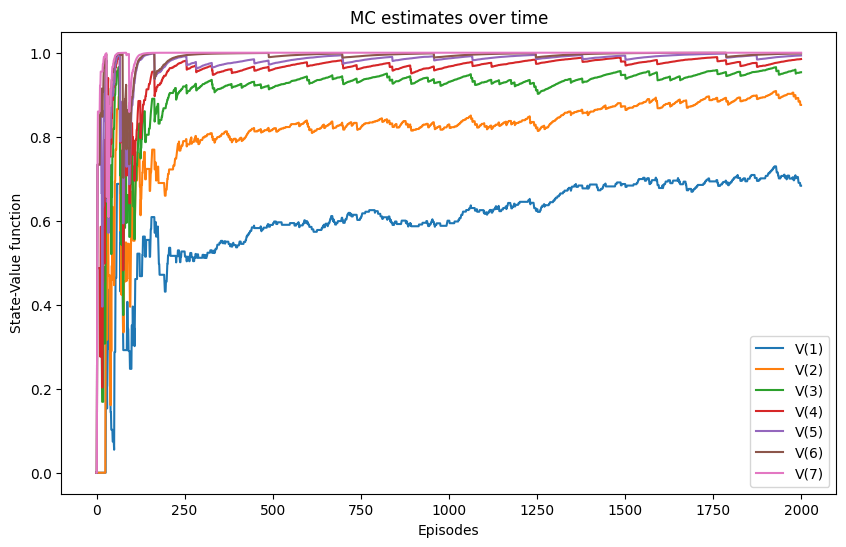

In [15]:
import matplotlib.pyplot as plt

legends = ['V(1)','V(2)','V(3)','V(4)','V(5)', 'V(6)', 'V(7)']

plt.figure(figsize=(10,6))
plt.plot(V_track_mc[:,1:8])
plt.title('MC estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)

plt.show()

Notice how **the estimates of MC have high variance**. We can use a brute-force approach to get the average return of the policy and its success probability.

In [56]:
def evaluate(env, pi, n_episodes=1000, max_steps=200):
    success = 0;
    results = []
    for _ in range(n_episodes):
        done = False;
        steps = 0;
        state = env.reset();
        results.append(0.0)
        while not done and steps < max_steps:
            state, reward, done, _ = env.step(pi(state))
            results[-1] += reward;
            steps += 1
        if(done and reward==1):
            success += 1;
    return (success/n_episodes)*100, np.mean(results);

In [63]:
probability_success, mean_return = evaluate(slippery_walk, pi_mc);

print("Reaches goal ", probability_success, "%");
print("Obtains an average undiscounted return of ", mean_return);

Reaches goal  92.80000000000001 %
Obtains an average undiscounted return of  0.928


## Improving policies after each step: SARSA

Monte Carlo method is **offline** method in an episode-to-episode sense: we must wait until a terminal state before we can make any improvements to the value function estimate. So, it is straightforward to apply **temporal-difference prediction** for the policy-evaluation phase in order to remove the limitation of Monte Carlo prediction. This algorithm is the well-known **SARSA agent** ([Rummery & Niranjan, "Online Q-Learning using Connectionist Systems" (1994)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.17.2539&rep=rep1&type=pdf)) :

$\displaystyle Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)] $

It uses the action taken in the next state to calculate the target.

SARSA error: $\displaystyle R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t) $

SARSA target: $\displaystyle R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) $

In [46]:
def sarsa(env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, init_epsilon=1.0, min_epsilon=0.1, decay_episodes=350, n_episodes=2000):
    
    nS, nA = env.observation_space, env.action_space
    
    pi_track = []
    Q = np.zeros((nS, nA), dtype=float)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
        
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes);
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes)
    
    for e in range(n_episodes):
        
        # we start episode by resetting the environment and the done flag
        state, done = env.reset(), False
        
        # select the action (perhaps exploratory) for the initial state
        action = select_action(state, Q, epsilons[e])
        
        # repeat until we hit a terminal state
        while not done:
            
            # step the environment and get the experience
            next_state, reward, done, _ = env.step(action)
            
            # obtain the action for the next step
            next_action = select_action(next_state, Q, epsilons[e])
            
            # calculate the td_target using that next state-action pair
            td_target = reward + gamma * Q[next_state][next_action]
            
            # calculate the td_error                                   
            td_error = td_target - Q[state][action]
            
            # update the action-value function
            Q[state][action] = Q[state][action] + alphas[e] * td_error
            
            # calculate the state-value function
            V = np.max(Q, axis=1)
            
            # update state and action for the next step
            state, action = next_state, next_action
            
        # save the value functions and the greedy policy for analysis    
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    # calculate the state-value function and its greedy policy
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, V_track, pi_track

Now we can run SARSA against the  Slippery Walk environment:

In [47]:
Q_sarsa, V_sarsa, pi_sarsa, Q_track_sarsa, V_track_sarsa, pi_track_sarsa = sarsa(slippery_walk)

In [48]:
print(V_sarsa)

[0.         0.57346004 0.78219831 0.90125992 0.95003106 0.97900896
 0.99124888 0.99709077 0.        ]


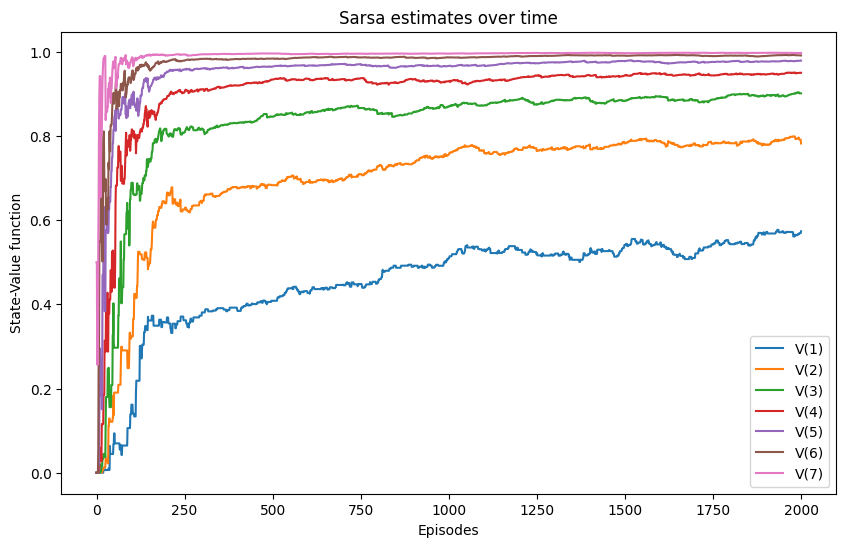

In [49]:
plt.figure(figsize=(10,6))

plt.plot(V_track_sarsa[:,1:8])
plt.title('Sarsa estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)

plt.show()

We can see how SARSA has less variance than MC, yet it takes pretty much the same amount of time to get to the optimal values.

In [74]:
probability_success, mean_return = evaluate(slippery_walk, pi_sarsa);

print("Reaches goal ", probability_success, "%");
print("Obtains an average undiscounted return of ", mean_return);

Reaches goal  92.7 %
Obtains an average undiscounted return of  0.927


Monte Carlo and SARSA must meet some requirements to guarantee convergence to the optimal policy: (a) **all state-action pairs must be explored infinitely often** and (b) **the policy must converge on a greedy policy**. In practice this means that an the epsilon-greedy exploration strategy must slowly decay epsilon towards zero. If it goes down too quickly, the first condition may not be met; if it decays too slowly, well, it takes longer to converge.

## Decoupling behavior from learning: Q-Learning

The SARSA algorithm is a sort of "learning on the job": **the agent learns about the same policy it uses for generating experience**. This type of learning is called **on-policy learning**. It is excellent, we learn from our own mistakes. But we learn from our own current mistakes only. What if we want to learn from our own previous mistakes? What if we want to learn from the mistakes of others? 

The **Off-policy learning** approach is sort of "learning from others": **the agent learns about a policy different from the one used to generate experiences**. There are two policies: a **behavior policy**, used to generate experiences and to interact with the environment, and a **target policy**, the one we are learning about. The most used off-policy algorithm is called **Q-Learning** ([Watkins, "Learning from Delayed Rewards" (1989)](https://www.cs.rhul.ac.uk/~chrisw/thesis.html))

The difference between SARSA and Q-learning is the action used to calculate the target. SARSA uses the action taken in the next state, Q-learning uses the action with the maximum estimated value in the next state, despite the action taken:

$\displaystyle Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma  \underset{a}{\text{ max }} Q(S_{t+1}, a) - Q(S_t, A_t)] $

Q-learning error: $\displaystyle R_{t+1} + \gamma  \underset{a}{\text{ max }} Q(S_{t+1}, a) - Q(S_t, A_t) $

Q-learning target: $\displaystyle R_{t+1} + \gamma  \underset{a}{\text{ max }} Q(S_{t+1}, a) $

Q-Learning algorithm will evaluate all possible state-actions pairs and choose that pair which will generate maximum expected rewards (which is the value of the state).

In [102]:
def q_learning(env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, init_epsilon=1.0, min_epsilon=0.1, decay_episodes=350, n_episodes=2000):
    nS, nA = env.observation_space, env.action_space
    
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)

    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes)
    
    for e in range(n_episodes):
        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q, epsilons[e])
            next_state, reward, done, _ = env.step(action)
            
            # calculate the target: here is Q-learning
            td_target = reward + gamma * Q[next_state].max()
            
            td_error = td_target - Q[state][action]

            Q[state][action] = Q[state][action] + alphas[e] * td_error
            V = np.max(Q, axis=1)

            state = next_state

        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)        
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, V_track, pi_track

Now we can run Q-Learning against the  Slippery Walk environment:

In [103]:
Q_q, V_q, pi_q, Q_track_q, V_track_q, pi_track_q = q_learning(slippery_walk)

In [104]:
print(V_q)

[0.         0.67391052 0.88103721 0.95629247 0.98599906 0.9956918
 0.9987202  0.99957481 0.        ]


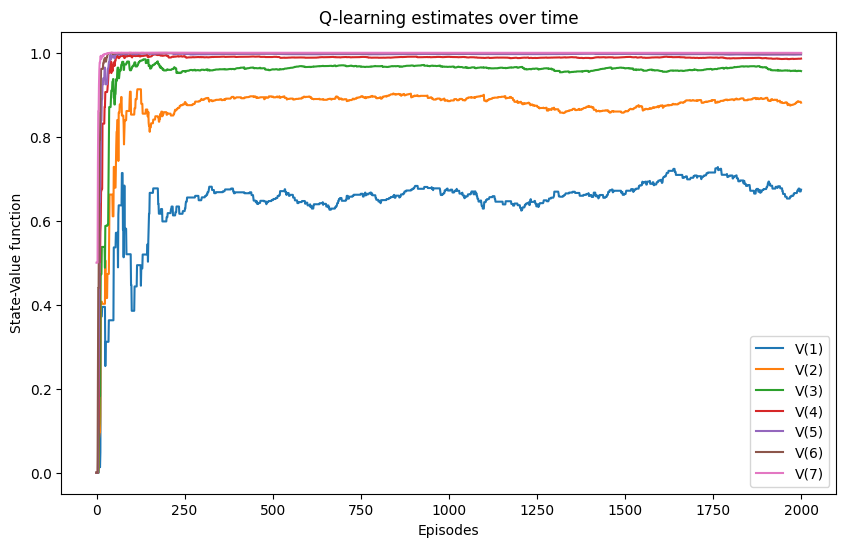

In [105]:
plt.figure(figsize=(10,6))

plt.plot(V_track_q[:,1:8])
plt.title('Q-learning estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)

plt.show()

See how much faster the estimates track the true values. But, also, notice how the estimates are often higher and jump around somewhat aggressively.

In [79]:
probability_success, mean_return = evaluate(slippery_walk, pi_q);

print("Reaches goal ", probability_success, "%");
print("Obtains an average undiscounted return of ", mean_return);

Reaches goal  93.89999999999999 %
Obtains an average undiscounted return of  0.939


Notice that for off-policy RL algorithms the only requirement that holds of the two for convergence is the first one (all state-action pairs must be explored infinitely often). The second one (he policy must converge on a greedy policy) is no longer a requirement because the learned policy is different than the one sued to sampling actions.

## Solving the maximization bias: Double Q-Learning

Notice tha Q-learning often **overestimates the value function**. On every step, we take the **maximum over the estimates** of the action-value function of the next state, but what we need is an **estimate of the maximum** of the action-value function of the next state. We are using the **maximum over estimates as an estimate of the maximum**. But these estimates are often biased. This is a problem known as **maximization bias**. Imagine an action-value function whose actual values are all zeros, but the estimates have bias (0.11, 0.65, –0.44, –0.26, and so on). We know the actual maximum is zero, but the maximum over the estimates is 0.65. 

One way of dealing with this is a technique called **double Q-learning** [Hasselt, Hado. "Double Q-learning." Advances in neural information processing systems NIPS (2010)](https://proceedings.neurips.cc/paper/2010/hash/091d584fced301b442654dd8c23b3fc9-Abstract.html). The idea is to maintain **two Q-value functions** QA and QB, each one gets update from the other for the next state. The update consists of finding the action a* that maximizes QA in the next state, then use a* to get the value of QB(s', a*) to be used to update QA(s, a). One Q-function estimates will help us validate the other Q-function estimates. The issue, though, is now we are splitting the experience between two separate functions and this somewhat **slows down training**.

In [106]:
def double_q_learning(env,gamma=1.0, init_alpha=0.5, min_alpha=0.01, init_epsilon=1.0, min_epsilon=0.1, decay_episodes=350, n_episodes=2000):
    
    nS, nA = env.observation_space, env.action_space
    pi_track = []
    
    # two state-value functions Q1 and Q2 
    Q1 = np.zeros((nS, nA), dtype=float)
    Q2 = np.zeros((nS, nA), dtype=float)
    
    Q_track = np.zeros((n_episodes, nS, nA), dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
    
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes)
    
    for e in range(n_episodes):
        state, done = env.reset(), False
        while not done:
            
            # use the mean of our two Q-functions to select action 
            action = select_action(state, (Q1 + Q2)/2, epsilons[e])

            next_state, reward, done, _ = env.step(action)
            
            # flip a coin to determine an update to Q1 or Q2
            if np.random.randint(2):

                # use the action Q1 thinks is best...
                argmax_Q1 = np.argmax(Q1[next_state])
                
                # ...but get the value from Q2 to calculate the target
                td_target = reward + gamma * Q2[next_state][argmax_Q1]
                td_error = td_target - Q1[state][action]
                
                # update Q1
                Q1[state][action] = Q1[state][action] + alphas[e] * td_error
            else:
                
                # use the action Q2 thinks is best...
                argmax_Q2 = np.argmax(Q2[next_state])
                
                # ...but get the value from Q1 to calculate the target
                td_target = reward + gamma * Q1[next_state][argmax_Q2]
                td_error = td_target - Q2[state][action]
                
                # update Q2
                Q2[state][action] = Q2[state][action] + alphas[e] * td_error
            
            state = next_state
        
        Q = (Q1 + Q2)/2.
        V = np.max(Q, axis=1)
        Q_track[e] = Q
        V_track[e] = V
        
        # notice the policy is the argmax of the mean of Q1 and Q2
        pi_track.append(np.argmax((Q1 + Q2)/2, axis=1))
    
    # the final Q is the mean
    Q = (Q1 + Q2)/2.

    V = np.max(Q, axis=1)    
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, V_track, pi_track

Now we can run Double Q-Learning against the  Slippery Walk environment:

In [107]:
Q_dq, V_dq, pi_dq, Q_track_dq, V_track_dq, pi_track_dq = double_q_learning(slippery_walk)

In [108]:
print(V_dq)

[0.         0.58577494 0.82323778 0.93096472 0.97240871 0.98998861
 0.99634582 0.99900613 0.        ]


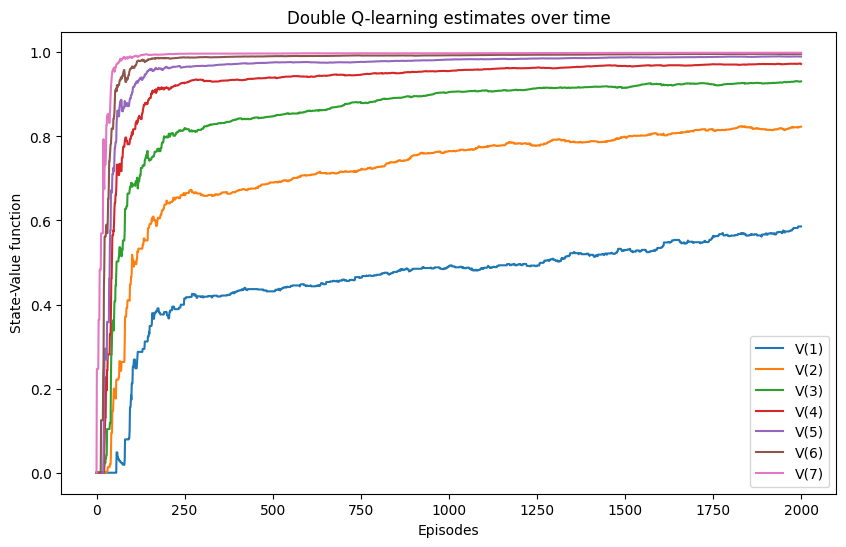

In [109]:
plt.figure(figsize=(10,6))

plt.plot(V_track_dq[:,1:8])
plt.title('Double Q-learning estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)

plt.show()

It is slightly slower than Q-learning to get the estimates to track the optimal state-value function, but it does so in a much more stable manner. There’s still a bit of over-estimation, but it’s controlled.

## Using multi-step estimates: SARSA(lambda)

SARSA(lambda) is a straightforward improvement to the original SARSA agent: **instead of using a one-step bootstrapping target, we use the lambda-return**. For adapting the eligibility trace to solving the control problem, instead of using the eligibility vector for tracking visited states, we use an **eligibility matrix for tracking visited state-action pairs**.

When the agent tries a state-action pair, the trace for this pair is incremented by one. Now, imagine there is a loop in the environment, and the agent tries the same state-action pair several times. Should we make this state-action pair **"more" responsible** for rewards obtained in the future, or should we make it **just responsible**? The type of eligibility trace that we used is called the **accumulating trace** and allows trace values higher than one. However, in reality, there are multiple ways of tracing state-action pairs responsible for a reward. For example, the **replacing trace** mechanism consists of clipping eligibility traces to a maximum value of one. The following figure shows the two strategy applied to the Slippery Walk environment:

<img src="./images/replacing-trace.png" width="900">

Accumulating traces can "exaggerate" when confronted with frequency while replacing traces moderate the blame assigned to frequent events. This moderation can help the more recent, but rare events surface and be taken into account.

In [93]:
def sarsa_lambda(env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, init_epsilon=1.0, min_epsilon=0.1, decay_episodes=350,
                lambda_=0.5, replacing_traces=True, n_episodes=2000):
    nS, nA = env.observation_space, env.action_space
    
    pi_track = []
    Q = np.zeros((nS, nA), dtype=float)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
    
    # eligibility traces
    E = np.zeros((nS, nA), dtype=float)

    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes)
    
    for e in range(n_episodes):
        # every new episode, set the eligibility of every state to zero
        E.fill(0)

        # select the action of the initial state
        state, done = env.reset(), False
        action = select_action(state, Q, epsilons[e])
        
        # interaction loop
        while not done:
            
            # step the environment and get the experience
            next_state, reward, done, _ = env.step(action)
            
            # obtain the action for the next step
            next_action = select_action(next_state, Q, epsilons[e])

            # calculate the td_target using that next state-action pair
            td_target = reward + gamma * Q[next_state][next_action]
            
            # calculate the td_error 
            td_error = td_target - Q[state][action]
            
            # increment the state-action pair trace, 
            # and clip it to 1 if it’s a replacing trace
            if replacing_traces: 
                E[state].fill(0)
            E[state][action] = E[state][action] + 1
            if replacing_traces: 
                E.clip(0, 1, out=E)
            
            # apply the TD error to all eligible state-action pairs at once
            # even though we’re using the entire Q-table, E will be mostly 0, 
            # and greater than zero for eligible pairs
            Q = Q + alphas[e] * td_error * E
            V = np.max(Q, axis=1)
            
            # decay the eligibility matrix
            E = gamma * lambda_ * E 
            
            # update state and action for the next step
            state, action = next_state, next_action

        # save the Q-function and greedy policy for analysis    
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    # calculate the V-function and its greedy policy
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, V_track, pi_track

We can apply the algorithm to the same SWS environment:

In [94]:
Q_sarsa_lambda, V_sarsa_lambda, pi_sarsa_lambda, Q_track_sarsa_lambda, V_track_sarsa_lambda, pi_track_sarsa_lambda = sarsa_lambda(slippery_walk)

In [95]:
print(V_sarsa_lambda)

[0.         0.56335873 0.81693792 0.91441186 0.96079547 0.98608268
 0.99506851 0.99867051 0.        ]


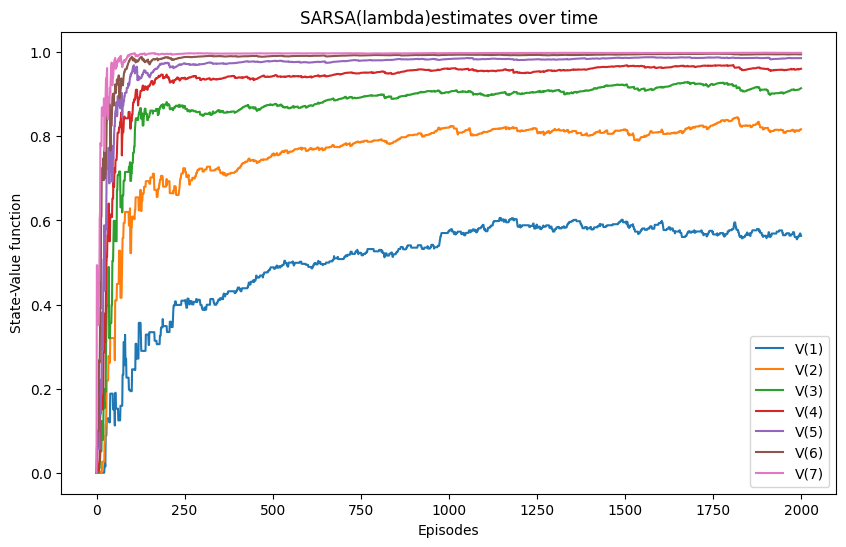

In [120]:
plt.figure(figsize=(10,6))

plt.plot(V_track_sarsa_lambda[:,1:8])
plt.title('SARSA(lambda)estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)

plt.show()

## Using multi-step estimates and decoupling behaviour from learning: Q(lambda)

Q(lambda) is an extension of Q-learning that uses the lambda-return for policy-evaluation. The only change we’re doing is replacing the TD target for off-policy control (the one that uses the max over the action in the next state) with a lambda-return for off-policy control.

In [114]:
def q_lambda(env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, init_epsilon=1.0, min_epsilon=0.1, decay_episodes=350,
             lambda_=0.5, replacing_traces=True, n_episodes=2000):
    
    nS, nA = env.observation_space, env.action_space
    
    pi_track = []
    Q = np.zeros((nS, nA), dtype=float)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
        
    E = np.zeros((nS, nA), dtype=float)
    
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes)
    
    for e in range(n_episodes):
        E.fill(0)
        
        state, done = env.reset(), False
        
        # notice: we are preselecting the action as in SARSA, (we didn’t do that in Q-learning) 
        # this is because we need to check whether our next action is greedy for deciding
        # to decay the eligibility trace
        action = select_action(state, Q, epsilons[e])
        
        while not done:
            
            next_state, reward, done, _ = env.step(action)
            
            # select the next_action SARSA-style
            next_action = select_action(next_state, Q, epsilons[e])
            
            # use it to verify that the action on the next step 
            # will still come from the greedy policy
            next_action_is_greedy = Q[next_state][next_action] == Q[next_state].max()

            # still calculate the TD target as in regular Q-learning, using the max
            td_target = reward + gamma * Q[next_state].max()
            
            # and use the TD target to calculate the TD error
            td_error = td_target - Q[state][action]
            
            if replacing_traces: 
                E[state].fill(0)
            E[state][action] = E[state][action] + 1
            if replacing_traces: 
                E.clip(0, 1, out=E)
            
            # as before, we multiply the entire eligibility trace matrix 
            # by the error and the learning rate corresponding to episode e, 
            Q = Q + alphas[e] * td_error * E
            V = np.max(Q, axis=1)
            
            # if the action we’ll take on the next state (which we already selected) is a greedy action, 
            # then we decay the eligibility matrix as usual, otherwise, we must reset 
            # the eligibility matrix to zero because we’ll no longer be learning about the greedy policy
            if next_action_is_greedy:
                E = gamma * lambda_ * E
            else:
                E.fill(0)

            state, action = next_state, next_action

        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)        
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, V_track, pi_track

We can apply the algorithm to the same SWS environment:

In [115]:
Q_q_lambda, V_q_lambda, pi_q_lambda, Q_track_q_lambda, V_track_q_lambda, pi_track_q_lambda = q_lambda(slippery_walk)

In [116]:
print(V_q_lambda)

[0.         0.6221715  0.86238886 0.94736618 0.98130875 0.99465299
 0.99859599 0.99963922 0.        ]


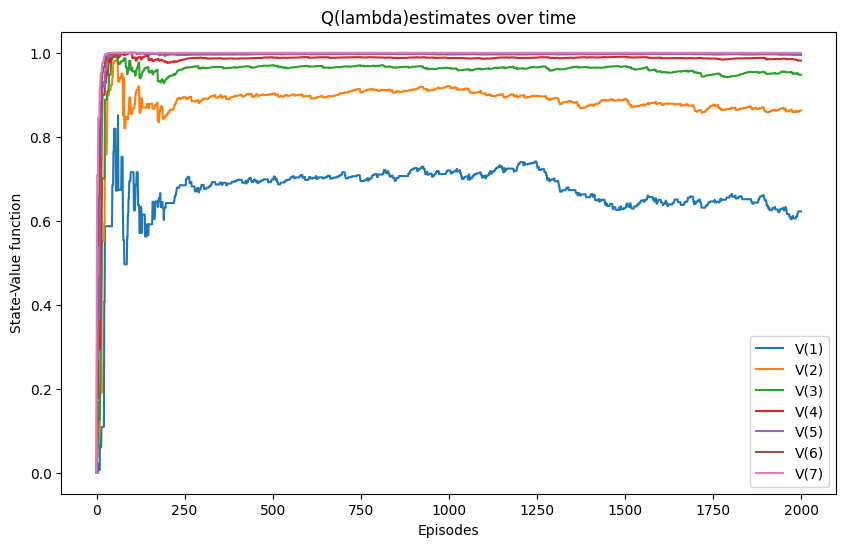

In [118]:
plt.figure(figsize=(10,6))

plt.plot(V_track_q_lambda[:,1:8])
plt.title('Q(lambda)estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)

plt.show()

## Comparison

In order to compare different algorithms, we can consider the state-value function estimation error. This is the Mean absolute error across all estimates from their respective optimal. Take a look at how quickly Q-learning drops near zero, but also how double Q-learning gets to the lowest error first. 

In [121]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

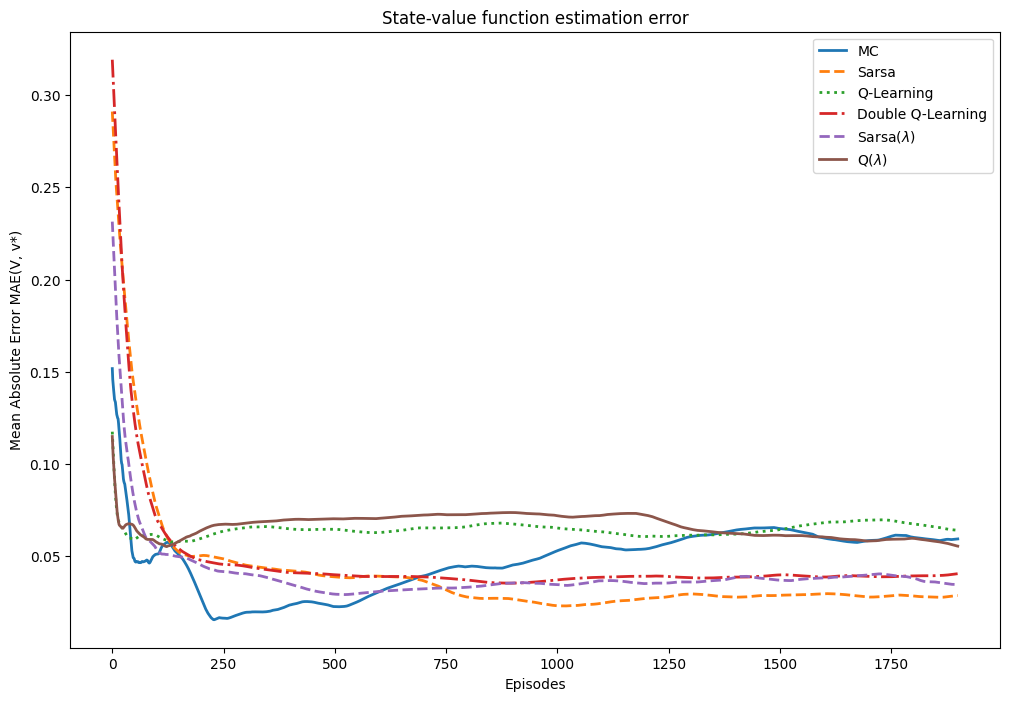

In [122]:
plt.figure(figsize=(12,8))

plt.plot(moving_average(np.mean(np.abs(V_track_mc - optimal_V), axis=1)), '-', linewidth=2, label='MC')
plt.plot(moving_average(np.mean(np.abs(V_track_sarsa - optimal_V), axis=1)), '--', linewidth=2, label='Sarsa')
plt.plot(moving_average(np.mean(np.abs(V_track_q - optimal_V), axis=1)), ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.mean(np.abs(V_track_dq - optimal_V), axis=1)), '-.', linewidth=2, label='Double Q-Learning')
plt.plot(moving_average(np.mean(np.abs(V_track_sarsa_lambda - optimal_V), axis=1)), '--', linewidth=2, label='Sarsa($\lambda$)')
plt.plot(moving_average(np.mean(np.abs(V_track_q_lambda - optimal_V), axis=1)), '-', linewidth=2, label='Q($\lambda$)')
plt.legend(loc=1, ncol=1)
plt.title('State-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(V, v*)')

plt.show()